# Лабораторна робота 3,4
В темі 3 **"Виявлення аномалій в часових рядах"** ми обговорили, як виявити аномалії в часових рядах за допомогою статистичного керування процесом і авторегресійних моделей. Тут ми застосуємо обидва підходи до реальних наборів даних.

Результати навчання
Ви повинні:

1. Розуміння виявлення аномалій часових рядів
2. Отримати практичний досвід із статистичним контролем процесів і авторегресійними моделями для виявлення аномалій у часових рядах.

# Імпорт

In [1]:
%matplotlib inline
#import warnings
#warnings.filterwarnings('ignore', category=FutureWarning)
import sys
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import random
import seaborn as sns
from scipy import stats
import statsmodels as ss
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

# Розділ 1: Статистичне управління процесом для виявлення аномалій¶ 
У цьому розділі ми збираємося використовувати статистичне керування процесом *statistical process control * (SPC) для виявлення аномалій у часових рядах. Як ми обговорювали на лекціях, SPC забезпечує контроль якості даних часових рядів.

#### Дані

Як приклад ми використаємо дані про кількість опадів за жовтень 2018 року для Нью-Йорка (зібрані в аеропорту імені Джона Кеннеді). Необроблені дані доступні на веб-сайті NOAA:

https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USW00094789/detail

Тут ми надаємо чисту версію даних. Ми внесли дві зміни до необроблених даних: (1) дати були записані у форматі, зручному для аналізу часових рядів, і (2) значення слідів опадів були замінені на нуль.

Зауваження: Позначення сліду, а не нуля, використовується для вказівки на те, що опади випали, але їх недостатньо для достовірного вимірювання

In [2]:
df_ppt = pd.read_csv('nyc_precipitation_oct2018.csv', parse_dates=True, index_col=0)
df_ppt.head()

C:\Users\bohda\AppData\Local\Temp\ipykernel_2540\3253402255.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_ppt = pd.read_csv('nyc_precipitation_oct2018.csv', parse_dates=True, index_col=0)


,Precipitation
Date,
2018-10-01,0.00
2018-10-02,0.33
2018-10-03,0.00
2018-10-04,0.04
2018-10-05,0.00


Опади вказуються в дюймах.

Дивіться, що багато днів без опадів і є великі значення 11, 12 і 27 жовтня. Візуалізуйте дані та узагальніть статистику.

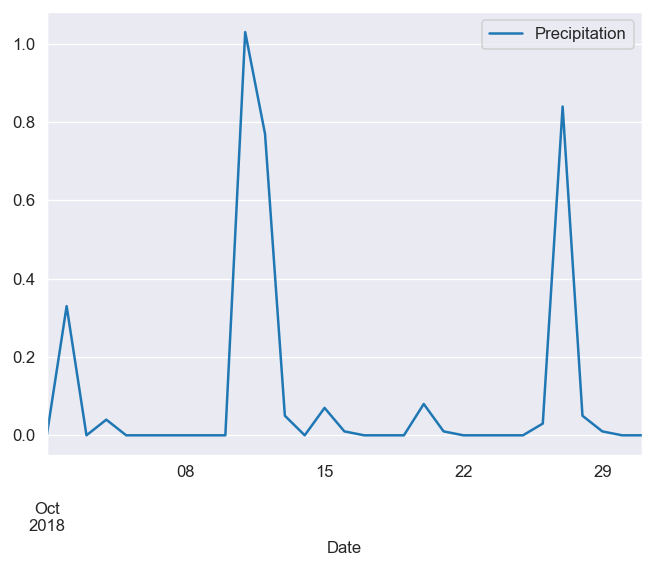

In [3]:
plt.figure(dpi=120)
df_ppt.plot(ax=plt.gca())
plt.show();

In [4]:
df_ppt.describe()

,Precipitation
count,31.000000
mean,0.107097
std,0.266573
min,0.000000
25%,0.000000
50%,0.000000
75%,0.045000
max,1.030000


Через багато днів без опадів середнє значення та стандартне відхилення досить малі, але велике максимальне значення свідчить про наявність принаймні однієї аномальної точки (11 жовтня 2018 р.).

## Контрольна діаграма (control plot)
Із підсумкової статистики та графіка ми можемо побачити, що будь-які аномалії будуть вищими за середнє значення, яке становить 0,107 дюйма, тому нам потрібен лише однобічний контрольний графік.

Є ще один спосіб дійти того ж висновку. Оскільки кількість опадів не може бути від’ємним числом, усі можливі значення нижче середнього лежать у діапазоні 0 <= кількість опадів <= 0,107 дюйма), які знаходяться в межах одного стандартного відхилення (0,267 дюйма) від середнього значення, і тому не є аномаліями.

Тому створимо односторонню контрольну діаграму.

In [5]:
def control_plot(time_series, threshold):
    '''
    Створює однобічний контрольний графік із часового ряду
     (тобто поріг графіків вище середнього, але не нижче)
     Також повертає список балів, які перевищують порогове значення
     тобто точки, для яких значення > середнє + порогове значення*(стандартне відхилення)
    
     Args:
         time_series: (кадр даних pandas; стовпець індексу – це дата у форматі datetime та
         стовпець 0 - дані)
         threshold: поріг z-показника для виявлення аномалії (float)

     Returns:
         Контрольний графік часового ряду
         аномалії: аномалії, які перевищують порогове значення (датафрейм pandas)
    ''' 
    
    mean_= time_series.iloc[:,0].mean()
    stdev_= time_series.iloc[:,0].std()
    cutoff = mean_+threshold*stdev_
    plt.figure(dpi=140)
    time_series.plot(ax=plt.gca())
    plt.axhline(y=mean_, color='g', linestyle='--', label='mean')
    # Використовуйте порогове значення для побудови лінії, що на  threshold*stdev_  відрізняються від середнього
    plt.axhline(y=cutoff, color='r', linestyle=':', label='threshold')
    plt.legend(loc='best')
    plt.title('NYC October 2018 precipitation')
    plt.ylabel('Precipitation (in.)')
    
    # Створіть датафрейм аномалій, які перевищують межу
    anomalies = time_series[time_series.values > cutoff]
    return anomalies

#### Встановіть порогове значення 3 стандартних відхилень і побудуйте результати.

In [6]:
anomaly_ppt = control_plot(df_ppt, 3)

Є аномалія. Отримайте дані для цієї точки.

In [7]:
print(anomaly_ppt)

            Precipitation
Date                     
2018-10-11           1.03


Цей результат узгоджується з нашим візуальним оглядом. (Для невеликих наборів даних дослідники добре вміють виявляти статистичні закономірності, наприклад, викиди, на око.)

### Кумулятивна сума (CUSUM)
Для порівняння застосуємо підхід CUSUM і подивимось, що ми знайдемо. Будемо використовувати схему алгоритму з лекції.

In [8]:
def cusum(data, mean, shift, threshold):
    '''
    Обчисліть високі та низькі кумулятивні суми та використовуйте їх для виявлення аномалій.
     Повідомляється про аномалію, якщо кумулятивні суми перевищують задане порогове значення.
    
     Args:
         data: (часовий ряд як датафрейм pandas; index column – це дата у форматі дати та часу
         column 0 - дані)
         mean: середнє значення даних або інше середнє (float)
         shift: нормальний зсув даних; рекомендоване стандартне відхилення (float)
         threshold: поріг для класифікації точки як аномалії (float)

     Returns:
         cusum: висока та низька кумулятивні суми разом із даними (датафрейм pandas)
         anomalies: аномалії вище та нижче порогу (датафрейм pandas)
       
    ''' 
    high_sum = 0.0
    low_sum = 0.0
    anomalies = [] 
    high_sum_final = []
    low_sum_final = []
    index_names = data.index
    data_values = data.values
    for index, item in enumerate(data_values):
        high_sum = max(0, high_sum + item - mean - shift)
        low_sum = min(0, low_sum + item - mean + shift)
        high_sum_final.append(high_sum)
        low_sum_final.append(low_sum)
        if high_sum > threshold or low_sum < -threshold:
            anomalies.append((index_names[index], item.tolist()))
    cusum = data
    cusum = cusum.assign(High_Cusum=high_sum_final, Low_Cusum=low_sum_final)
    return cusum, anomalies

І ми також побудуємо діаграму результати нашого аналізу CUSUM.

In [9]:
def cusum_plot(time_series, threshold):
    '''
    Побудуйте високі та низькі кумулятивні суми та використовуйте їх для виявлення аномалій.
     Повідомляється про аномалію, якщо кумулятивні суми перевищують задане порогове значення.
    
     Args:
         time_series: (часовий ряд як датафрейм даних pandas; index column є датою
         у форматі дати й часу, а column 0 — дані)
         threshold: поріг для класифікації точки як аномалії (float)

     Returns:
         Діаграма даних із високою кумулятивною сумою.
         cusum_results: висока та низька кумулятивні суми разом із даними
         а також будь-які аномалії, які перевищують або перевищують порогове значення (датафрейм даних pandas;
         з функції cumsum)
    
    ''' 
    # Використовуйте середнє значення та стандартне відхилення всього часового ряду
     # для обчислення кумулятивних сум
    mean_= time_series.iloc[:,0].mean()
    stdev_= time_series.iloc[:,0].std()
    
# визначити порогове значення в термінах стандартного відхилення
    cusum_results = cusum(time_series, mean_, stdev_, threshold*stdev_)
    ax=time_series.plot()
    ax.axhline(y=mean_, color='g', linestyle='--',label='average')
    ax.axhline(y=mean_+threshold*stdev_, color='r', linestyle='--',label='High threshold')
    # Використовуйте threshold, щоб побудувати лінію на threshold*stdev_ відхилену від середнього
    ax.scatter(x=cusum_results[0].index, y=cusum_results[0]['High_Cusum'], 
             color='k', linestyle=':',label='High Cusum')                      
    plt.legend(loc='center left')
    plt.title('NYC October 2018 precipitation')
    plt.ylabel('Precipitation (in.)')
    plt.gcf().set_size_inches(8,6)
    plt.show()
    
    return cusum_results

Вибір порогового значення: для контрольної діаграми ми використовували 3-кратне стандартне відхилення. Зауважте, що еквівалентним порогом для CUSUM є **threshold=2**, оскільки CUSUM включає зсув (який ми вибрали як одне стандартне відхилення) у своєму обчисленні кумулятивної суми.

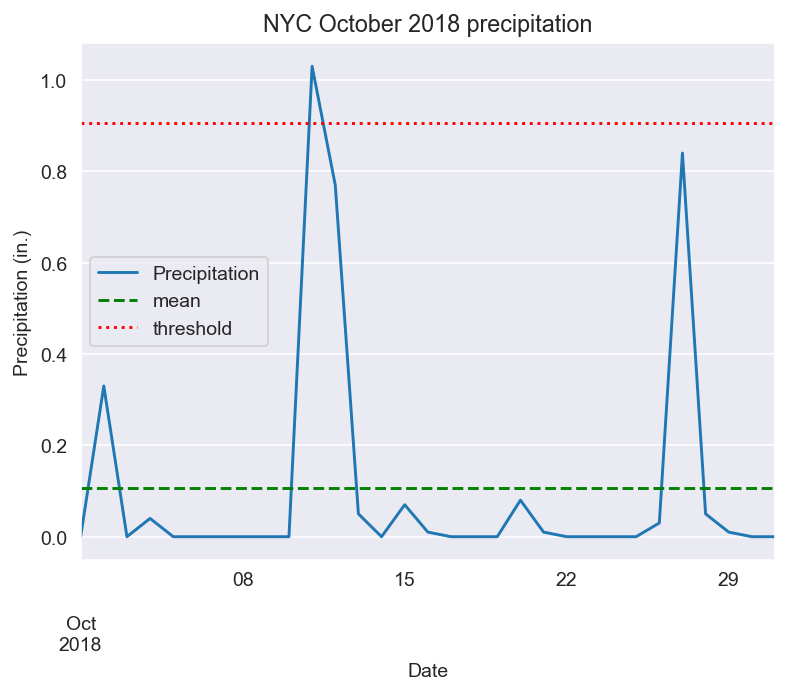

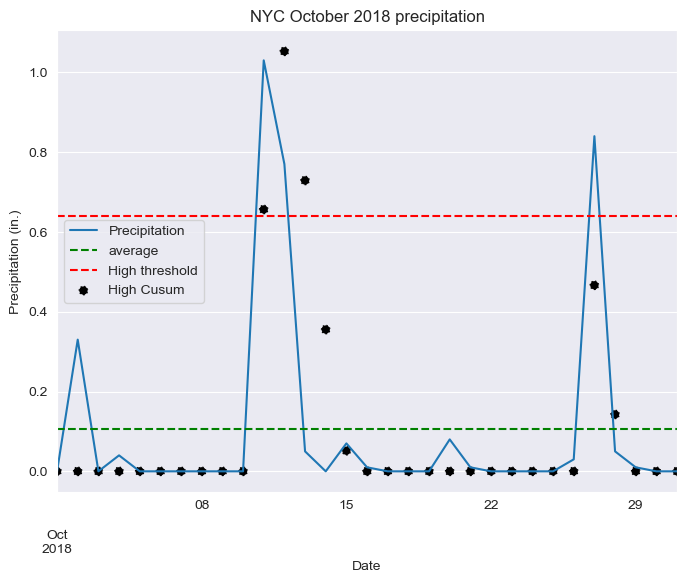

In [10]:
cusum_plot(df_ppt, 2);

Зауважте, що CUSUM знаходить ту саму аномалію, що й контрольна діаграма (1,03 дюйма 11 жовтня 2018 року), але він також позначає дві послідовні точки як аномалії. Чому?

Різні результати відображають різницю в алгоритмах. Контрольна діаграма шукає поодинокі аномальні точки. CUSUM чутливий до змін у поведінці даних. У результаті він позначає точки як аномальні, доки поведінка часового ряду не повернеться до нормального.

Дійсно, CUSUM використовується для виявлення точки зміни: визначення того, коли змінився основний розподіл часового ряду.

**Коментар.* Ми використали всі дані для обчислення базової статистики (середнього значення та стандартного відхилення) для виявлення аномалії. Хоча цей підхід іноді використовується, наявність аномалій у даних може спотворити базову статистику. Більш суворий підхід полягає у виборі даних, які вважаються нормальними, використанні цих даних для розрахунку базової статистики і лише потім виявленні аномалій. Ми розглянемо цю ідею у вправі 1.

## Розділ 2: Автогресивні моделі
Поки що ми проводили аналіз в офлайн-режимі --- ми мали під рукою всі цікаві дані. У результаті, досліджуючи будь-яку дану точку, ми можемо використовувати як минуле, так і майбутнє (щодо цієї точки) для обчислення статистичних даних, таких як середнє значення та стандартне відхилення.

Часто ми зацікавлені в аналізі часових рядів у потоковому режимі --- тобто, коли дані стають доступними. У цьому випадку будь-які моделі, які ми використовуємо для виявлення аномалій, можуть використовувати лише минуле (стосовно даної точки). Майбутні дані недоступні.

Як обговорювалося на лекціях, авторегресійні моделі зазвичай використовуються для виявлення аномалій потоку, і ми розглянемо одну з таких моделей нижче.

### Дані
Ми будемо використовувати інший набір даних про погоду з Нью-Йорка (зібраний в аеропорту Джона Кеннеді): максимальні та мінімальні добові температури з 1 лютого 1959 року по 31 жовтня 2018 року.

Необроблені дані доступні на веб-сайті NOAA, який ми використовували:

https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USW00094789/detail

Тут ми надаємо чисту версію даних. Ми обробили необроблені дані таким чином: (1) дати були записані у форматі, зручному для аналізу часових рядів, і (2) два відсутні значення були заповнені.

Дві дати, які не мали жодних значень (як для максимальної, так і для мінімальної температури), були 1 грудня 1959 року та 1 травня 1960 року. Для цілей цього блокнота ми додали аномальні значення до цих дат, як показано нижче. (Якби ми не вивчали виявлення аномалій, ми б додали значення, що відповідають середнім температурам за день до і після дня, щоб уникнути прогалин у часових рядах.)

In [11]:
df_nyc_temp = pd.read_csv('nyc_daily_temp_final.csv', parse_dates=True, index_col=0)

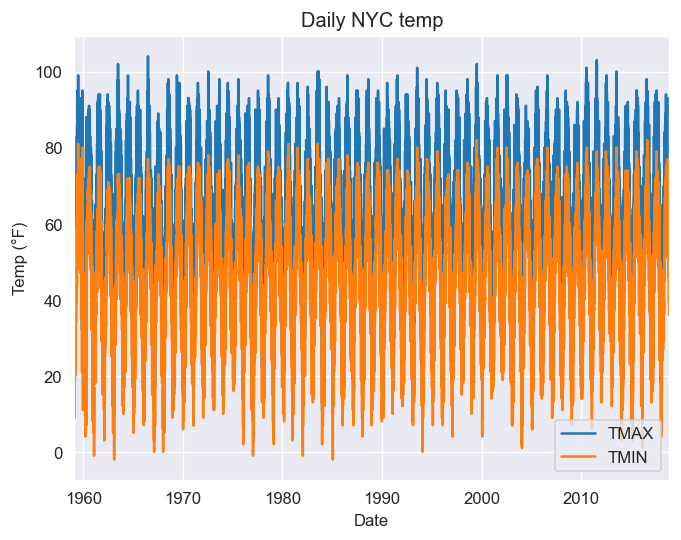

In [12]:
plt.figure(dpi=120)
df_nyc_temp.plot(ax=plt.gca())
plt.title('Daily NYC temp')
plt.xlabel('Date')
plt.ylabel('Temp (°F)')
plt.show()

Нелегко побачити, чи є аномалії з такою кількістю точок. Давайте подивимося на статистику як для TMAX (максимальна добова температура), так і для TMIN (мінімальна добова температура).

In [13]:
df_nyc_temp.describe()

,TMAX,TMIN
count,21823.000000,21823.000000
mean,61.548091,47.129496
std,17.585690,16.468738
min,8.000000,-2.000000
25%,48.000000,34.000000
50%,62.000000,47.000000
75%,77.000000,62.000000
max,104.000000,82.000000


Найвище значення TMAX (104 °F) і найнижче значення TMIN (-2 °F) є досить екстремальними. Але чи це аномалії?

А як щодо аномалій, які ми внесли в дати з відсутніми значеннями?

Для 1 грудня 1959 року TMAX і TMIN на 40 °F тепліші, ніж прогнозує лінійна інтерполяція.

In [14]:
df_nyc_temp.loc['1959-11-30':'1959-12-02']

,TMAX,TMIN
DATE,,
1959-11-30,38,26
1959-12-01,95,80
1959-12-02,51,33


Для 1 травня 1960 року TMAX і TMIN на 40°F холодніші, ніж передбачила б лінійна інтерполяція.

In [15]:
df_nyc_temp.loc['1960-4-30':'1960-5-02']

,TMAX,TMIN
DATE,,
1960-04-30,60,50
1960-05-01,22,7
1960-05-02,64,43


Чи будемо ми виявляти ці точки як аномалії?

### Моделювання
Ми будемо використовувати модель авторегресії для виявлення аномалій. Тут ми розглянемо TMAX і залишимо TMIN для вправи 2.

Ми починаємо зі створення фрейму даних лише TMAX

In [16]:
df_nyc_tmax=df_nyc_temp[['TMAX']]

Переконайтеся, що новий фрейм даних відповідає очікуванням.

In [17]:
df_nyc_tmax.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21823 entries, 1959-02-01 to 2018-10-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   TMAX    21823 non-null  int64
dtypes: int64(1)
memory usage: 857.0 KB


In [18]:
df_nyc_tmax.head()

,TMAX
DATE,
1959-02-01,24
1959-02-02,26
1959-02-03,38
1959-02-04,44
1959-02-05,46


Як базову лінію для моделі авторегресії ми можемо перевірити, що контрольний графік показує як аномалії. На відміну від прикладу з опадами, тут ми можемо мати аномалії по обидва боки від середнього, тому ми змінюємо control_plot, щоб стати повним, двостороннім контрольним графіком.

In [19]:
def control_plot_full(time_series, threshold):
    '''
    Створює двосторонню контрольну діаграму з часового ряду
     (порогове значення вище та нижче середнього)
     Також повертає список точок, які перевищують порогове значення
     тобто точки, для яких значення > середнє + порогове значення*(стандартне відхилення)
     і значення < середнього - порогове значення * (стандартне відхилення)
    
     Args:
         time_series: (датафрейм даних pandas; index column – це дата у форматі datetime та
         column 0 - дані)
         threshold: поріг для виявлення аномалії (float)

     Returns:
         Контрольна діаграма часового ряду
         аномалії: аномалії, які перевищують порогове значення (датафрейм даних pandas)
    
    ''' 
    
    mean_= time_series.iloc[:, 0].mean()
    stdev_= time_series.iloc[:, 0].std()
    time_series.plot()
    plt.axhline(y=mean_, color='g', linestyle='--',label='average')
    # Використовуйте threshold, щоб побудувати лінію на threshold*stdev_ відхилену від середнього
    plt.axhline(y=mean_+threshold*stdev_, color='r', linestyle=':', label='high threshold')
    plt.axhline(y=mean_-threshold*stdev_, color='m', linestyle=':', label='low threshold')
    plt.legend(loc='upper right')
    plt.title('NYC Temperature')
    plt.ylabel('Temp (F)')
    plt.gcf().set_size_inches(8,6)
    plt.show()
    
    # Створити фрейм даних аномалій, які перевищують порогове значення
    anomaly_mask = (np.abs(time_series.values - mean_) > threshold*stdev_)
    anomalies = time_series[anomaly_mask]
    return anomalies

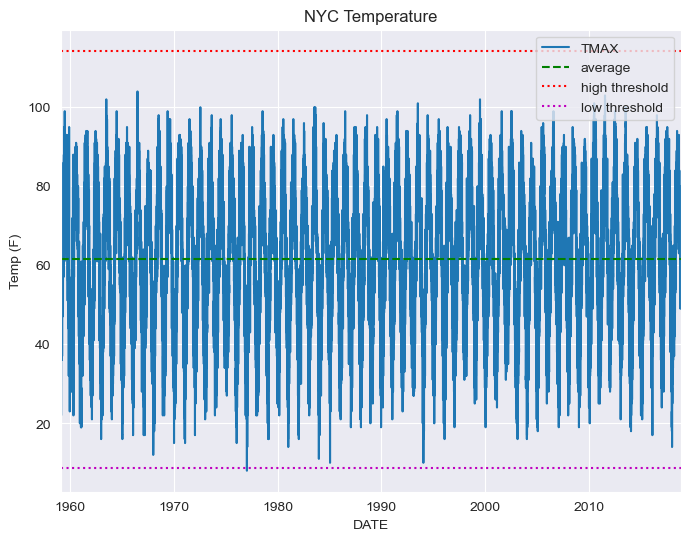

,TMAX
DATE,
1977-01-17,8


In [20]:
control_plot_full(df_nyc_tmax, 3)

Ми знаходимо лише одну аномалію: мінімум TMAX.

Переходимо до нашої моделі авторегресії. Огляд таких моделей (з посиланнями для подальшого вивчення) подано в лекції; детальне обговорення виходить за рамки уроків з виявлення аномалій.

**Примітка_1**. Щоб знайти успішну модель авторегресії, може знадобитися значна робота, і ми не стверджуємо, що представлена тут модель є оптимальною. Параметри вибрано так, щоб мати прийнятний час роботи.

**Примітка_2**: існують моделі, які явно включають _сезонні ефекти_ під час моделювання, як-от функція statsmodels SARIMAX. Довжина повного циклу не може бути надто довгою для сходження рядів, тому річні сезони погано працюють із щоденними даними (кожен сезон складається з 365 точок даних). У цьому випадку зазвичай використовується більш складна процедура, наприклад аналіз Фур’є з наступним відніманням річної складової.

**Примітка_3**: моделі авторегресії в Python вимагають, щоб аналізовані часові ряди мали відповідну частоту дат, тому важливо перевіряти відсутні значення на етапі попередньої обробки. Якщо time_series повний, багато пакетів, які мають справу з time_series, можуть визначити частоту, навіть якщо вона не надається.

In [21]:
print(df_nyc_tmax.index.inferred_freq)

D


Щоденна частота. Добре! Давайте зробимо це явним!

In [22]:
df_nyc_temp.index.freq=df_nyc_tmax.index.inferred_freq

А тепер узгоджуємо наші дані з моделлю.

In [23]:
tmax_sar=ARIMA(df_nyc_tmax, order=(1,1,4)).fit()

tmax_sar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   TMAX   No. Observations:                21823
Model:                 ARIMA(1, 1, 4)   Log Likelihood              -71865.154
Date:                Thu, 27 Feb 2025   AIC                         143742.307
Time:                        21:11:31   BIC                         143790.251
Sample:                    02-01-1959   HQIC                        143757.927
                         - 10-31-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0868      0.163      0.534      0.593      -0.232       0.405
ma.L1         -0.4544      0.162     -2.797      0.005      -0.773      -0.136
ma.L2         -0.2280      0.061     -3.768      0.000      -0.347      -0.109
ma.L3         -0.0528      0.044     -1.195      0.232      -0.139       0.034
ma.L4         -0.0310      0.016     -1.884      0.060      -0.063       0.001
sigma2        42.4612      0.336    126.411      0.000      41.803      43.120
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               855.18
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                             0.04
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Ми не будемо обговорювати представлену статистику, за винятком того, що вона включає стандартне відхилення залишків (6,516=42,4612^0,5), яке ми використаємо пізніше.

Ми перевіряємо діагностику, щоб перевірити, чи виконуються припущення, що лежать в основі моделі, а також отримати додаткову інформацію про якість підгонки. Це робиться за допомогою графіка Q-Q (перевірка того, що залишки відповідають нормальному розподілу), дослідження залишків на часові моделі та побудова гістограми залишків

In [24]:
# Отримайте прогнозоване стандартне відхилення. Це 6,516, які ми бачили раніше
sigma_pred = tmax_sar.resid.std()
# Обчисліть стандартизовані залишки з (звичайних) залишків
tmax_std_resid = tmax_sar.resid/sigma_pred
plt.axhline(y=4, color='r', linestyle=':', label='high threshold')
plt.axhline(y=-4, color='m', linestyle=':', label='low threshold')
plt.title('Patterns in residual')
plt.legend(loc='upper right')
plt.plot(tmax_std_resid);

In [25]:
print(sigma_pred)

6.5183408142044925


In [26]:
fig = plt.figure(figsize=(12,6))
ax = plt.subplot(121)
plt.title('Distribution of residuals')
sns.histplot(tmax_std_resid.values, bins=50, ax=ax);
stats.probplot(tmax_std_resid.values, dist='norm', sparams=(2.5,), plot=plt.subplot(122));

Для виявлення аномалій ми зосереджуємося на верхньому графіку: стандартизовані залишки. Стандартизований залишок — це залишок (різниця між спостережуваним значенням і прогнозованим значенням), поділений на прогнозоване стандартне відхилення (квадратний корінь із прогнозованої дисперсії, про яку ми згадували вище). Це більш складна версія z-показника, яку ми обговорювали в лабораторній 1.

**Емпіричне правило для виявлення аномалій зі стандартизованими залишками:** аномалії – це точки, для яких величина стандартизованих залишків перевищує 4. Давайте знайдемо ці точки.

In [27]:
# Повідомте про аномалії
anomaly_mask = np.abs(tmax_std_resid) > 4
tmax_anomalies = tmax_std_resid[anomaly_mask]
print(tmax_anomalies)

DATE
1959-12-01    7.878599
1959-12-02   -4.251382
1960-03-28    4.139199
1960-04-25    4.132208
1960-05-01   -6.161220
1977-04-12    6.162723
1978-01-10   -4.096459
1990-03-13    5.050174
1990-03-24   -4.052199
1991-03-28    4.064322
1998-03-27    4.770195
1998-03-29    4.051903
1998-12-23   -4.312631
2003-04-16    4.244040
2007-03-27    4.598190
2014-01-07   -4.120865
dtype: float64


Наша модель виявила обидві введені аномалії (1 грудня 1959 року та 1 травня 1960 року).

Модель не виявила єдиної аномалії, виявленої на контрольному графіку (17 січня 1977 р.), але вона знайшла кілька інших, які не були виявлені контрольним графіком.

Наступним кроком буде зміна параметрів моделі авторегресії та перевірка надійності цих висновків, але оскільки це належить до сфери аналізу часових рядів, ми зупинимося тут.

При підборі сезонних моделей ARIMA (як, втім, будь-яких інших моделей), необхідно провести діагностику моделі, щоб переконатися, що жодне з припущених, зроблених моделей, не було пошкоджено. Об'єкт plot_diagnostics дозволяє швидко провести діагностику моделі та дослідити будь-яку незвичайну поведінку.

Графіки, які з'явилися раніше, можна одночасно вивести на екрани. Головне завдання – переконатися, що залишки моделі некорельовані та розподіляються з нульовим середнім значенням. Якщо сезонна модель ARIMA не задовольняє ці властивості, це означає, що її можна покращити.

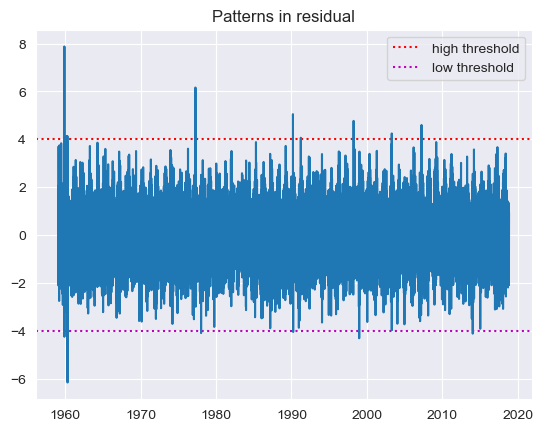

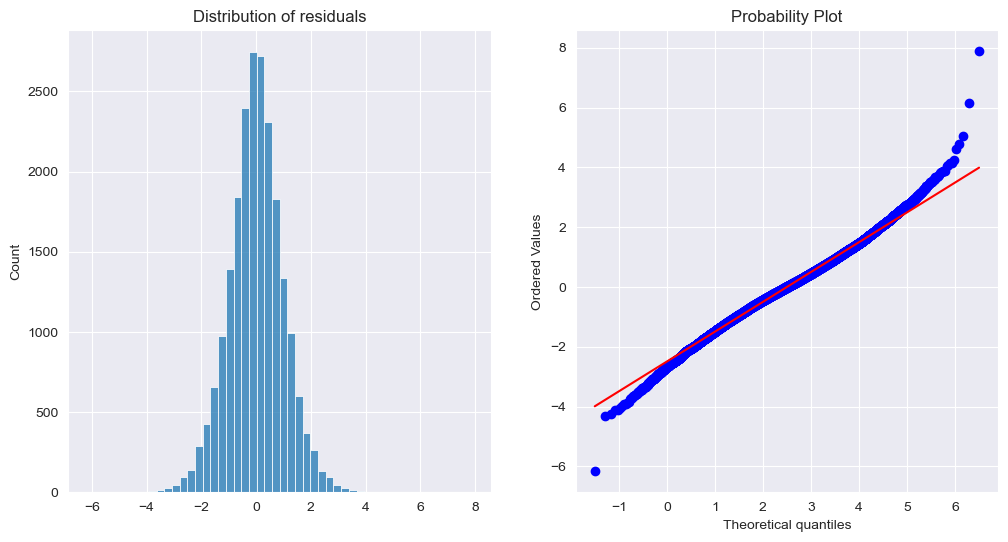

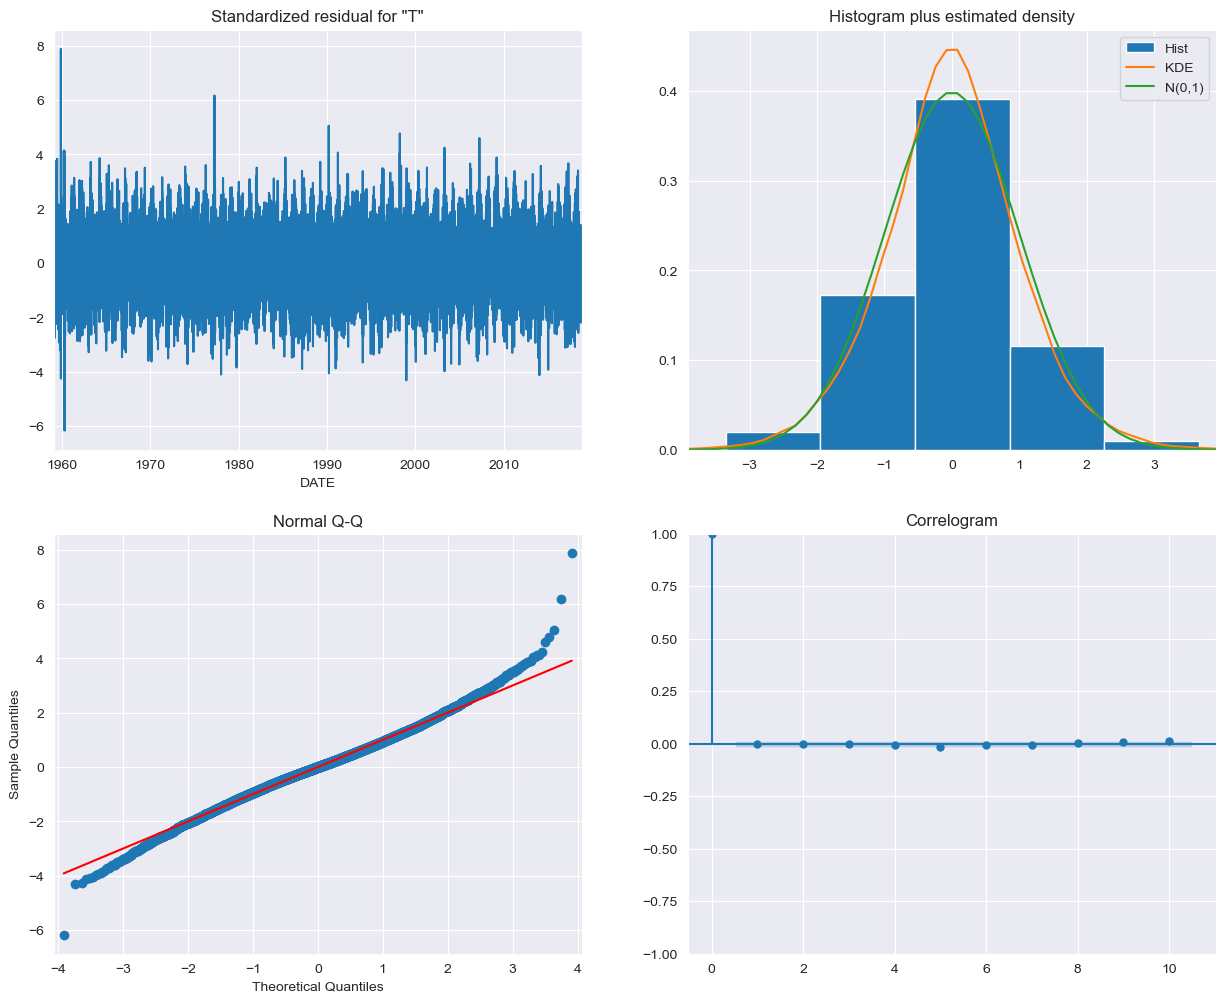

In [28]:
tmax_sar.plot_diagnostics(figsize=(15, 12))
plt.show()

У цьому випадку діагностика показала, що залишки моделі правильно розподіляються:

На верхньому правому графіку червона лінія KDE знаходиться приблизно до лінії N (0,1) (де N (0,1) є стандартним позначенням нормального розподілу із середнім 0 та стандартним відхиленням 1) . Це хороша ознака того, що залишки нормально розподілені.

Графік q-q у лівому нижньому куті показує, що впорядкований розподіл залишків (сині точки) слідують лінійному тренду вибору, взятих зі стандартного розподілу N (0, 1). Знову ж таки, це ознака того, що залишки нормально розподілені.

Залишки з часом (верхній лівий графік) не показують явну сезонність і здаються білими шумами. Це підтверджується графіком автокореляції (внизу праворуч), який показує, що залишки часових рядів мають низьку кореляцію з даними, що запізнюються.
Ці графіки можуть зробити висновок про те, що обрана модель (задовільно) підходить для аналізу та прогнозування даних часових рядів.

Ми вибрали задовільну модель, але деякі параметри сезонної моделі ARIMA можна покращити.

Скористайтесь методом auto_arima() з бібліотеки pmdarima для знаходження оптимальних параметрів моделі SARIMA.

In [29]:
# import necessary libraries

import pmdarima as pm

# set seasonal to True
seasonal = True

# use pmdarima to automatically select best ARIMA model
model = pm.auto_arima(df_nyc_tmax, 
                      m=1,               # frequency of series                      
                      seasonal=seasonal,  # TRUE if seasonal series
                      d=None,             # let model determine 'd'
                      test='adf',         # use adftest to find optimal 'd'
                      start_p=0, start_q=0, # minimum p and q
                      max_p=6, max_q=3, # maximum p and q
                      D=None,             # let model determine 'D'
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

# print model summary
print(model.summary())

D:\minicond\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\minicond\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\minicond\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\minicond\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\minicond\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\minicond\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarni

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=187070.805, Time=0.27 sec


D:\minicond\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=146989.449, Time=0.82 sec


D:\minicond\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=168761.351, Time=2.64 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=243459.113, Time=0.15 sec


D:\minicond\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\minicond\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=146347.991, Time=1.71 sec


D:\minicond\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=145357.031, Time=2.46 sec


D:\minicond\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=144932.452, Time=1.93 sec


D:\minicond\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=144565.957, Time=3.84 sec


D:\minicond\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(6,0,0)(0,0,0)[0] intercept   : AIC=144295.758, Time=5.15 sec


D:\minicond\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(6,0,1)(0,0,0)[0] intercept   : AIC=143680.114, Time=27.82 sec


D:\minicond\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=143684.257, Time=23.42 sec


D:\minicond\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(6,0,2)(0,0,0)[0] intercept   : AIC=143685.241, Time=23.34 sec


D:\minicond\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,2)(0,0,0)[0] intercept   : AIC=143703.806, Time=17.10 sec


D:\minicond\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(6,0,1)(0,0,0)[0]             : AIC=143737.014, Time=14.38 sec

Best model:  ARIMA(6,0,1)(0,0,0)[0] intercept
Total fit time: 125.113 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                21823
Model:               SARIMAX(6, 0, 1)   Log Likelihood              -71831.057
Date:                Thu, 27 Feb 2025   AIC                         143680.114
Time:                        21:13:40   BIC                         143752.030
Sample:                    02-01-1959   HQIC                        143703.543
                         - 10-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2429      0.038      6.470      0.000       0

Best model:  ARIMA(5,0,1)(0,0,0)[0]

In [30]:
tmax_sar_best=ARIMA(df_nyc_tmax, order=(5,0,1)).fit()

In [31]:
# Отримайте прогнозоване стандартне відхилення. 
sigma_pred = tmax_sar_best.resid.std()
# Обчисліть стандартизовані залишки з (звичайних) залишків
tmax_std_resid = tmax_sar_best.resid/sigma_pred
plt.axhline(y=4, color='r', linestyle=':', label='high threshold')
plt.axhline(y=-4, color='m', linestyle=':', label='low threshold')
plt.title('Patterns in residual')
plt.legend(loc='upper right')
plt.plot(tmax_std_resid);

In [32]:
print(sigma_pred)  #Було 6,516, які ми бачили раніше

6.510126995713651


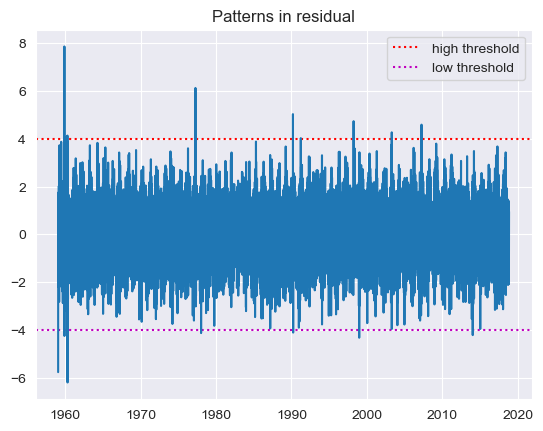

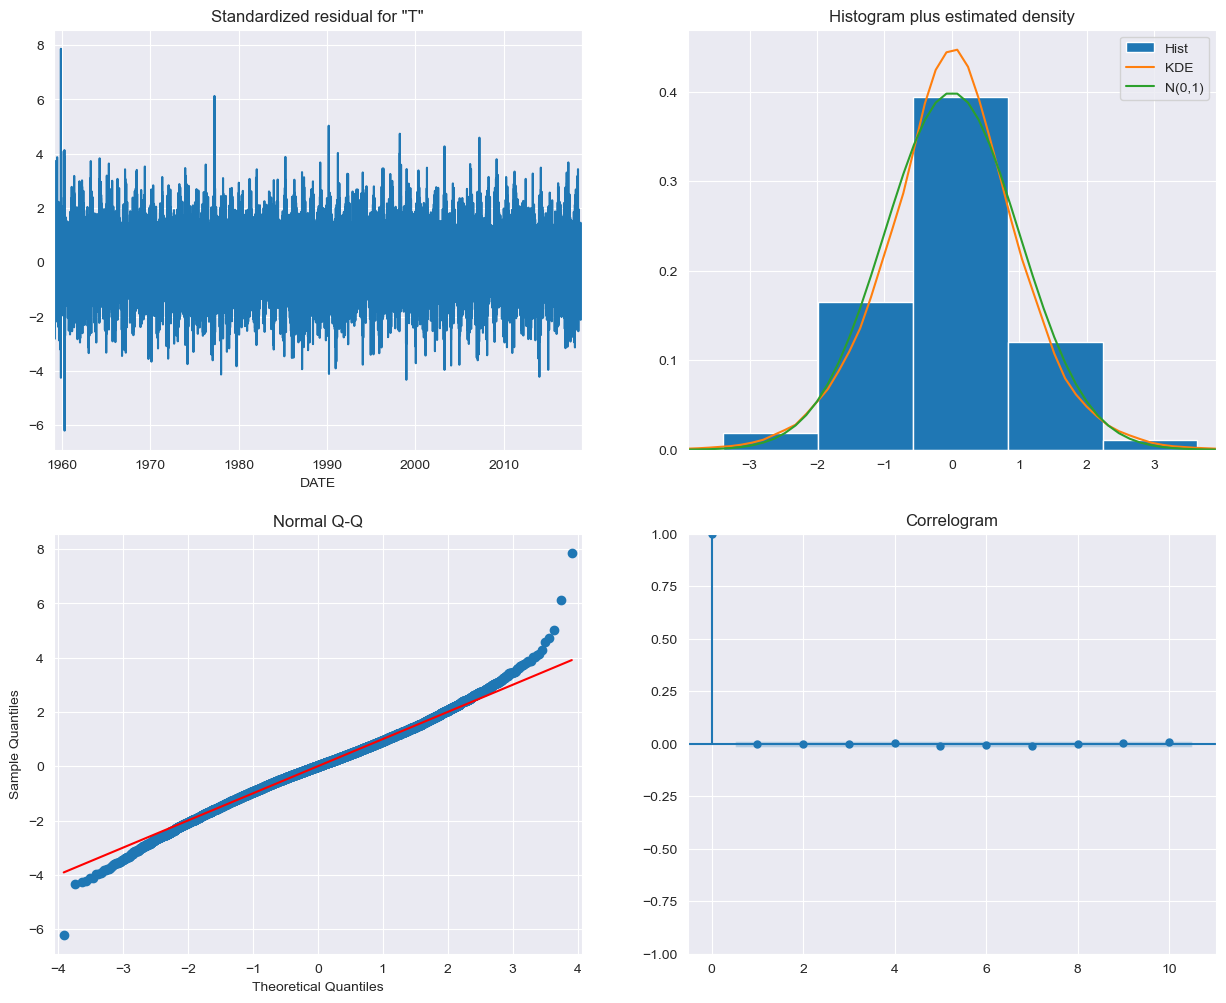

In [33]:
tmax_sar_best.plot_diagnostics(figsize=(15, 12))
plt.show()

In [34]:
# Повідомте про аномалії
anomaly_mask = np.abs(tmax_std_resid) > 4
tmax_anomalies = tmax_std_resid[anomaly_mask]
print(tmax_anomalies)

DATE
1959-02-01   -5.766411
1959-12-01    7.858880
1959-12-02   -4.252561
1960-03-28    4.085779
1960-04-25    4.130181
1960-05-01   -6.198951
1977-04-12    6.122815
1978-01-10   -4.132000
1990-03-13    5.027795
1990-03-24   -4.111702
1991-03-28    4.024124
1998-03-27    4.733396
1998-03-29    4.021510
1998-12-23   -4.327032
2003-04-16    4.266950
2007-03-27    4.587722
2014-01-07   -4.216798
dtype: float64


## Вправа №1¶
Ця вправа відноситься до розділу 1 (статистичне керування процесом).

A. Виберіть підмножину даних про опади, які, на вашу думку, не мають аномалій (наприклад, перші 10 днів). Використовуйте ці дані для обчислення середнього значення та стандартного відхилення.

B. Повторіть аналіз контрольної діаграми.

C. Порівняйте виявлені вами аномалії з тими, які були знайдені раніше.

## Рішення №1¶
Наявність аномалій у даних при обчисленні базових статистик (середнього значення та середнього квадратичного відхилення)  може дати помилкові значення цих базових статистик. Розглянемо більш строгий підхід, який передбачає обчислення базових статистик для відібраних  даних, які вважаються нормальними, використовуються ці дані для розрахунку базової статистики. І лише потім виявляємо аномалії з повного набору даних.

Виберемо для знаходження базової статистики, наприклад, перші 10 точок із початкового набору даних, які умовно будемо вважати нормальними.

C:\Users\bohda\AppData\Local\Temp\ipykernel_2540\773771283.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_ppt = pd.read_csv("nyc_precipitation_oct2018.csv", parse_dates=True, index_col=0)


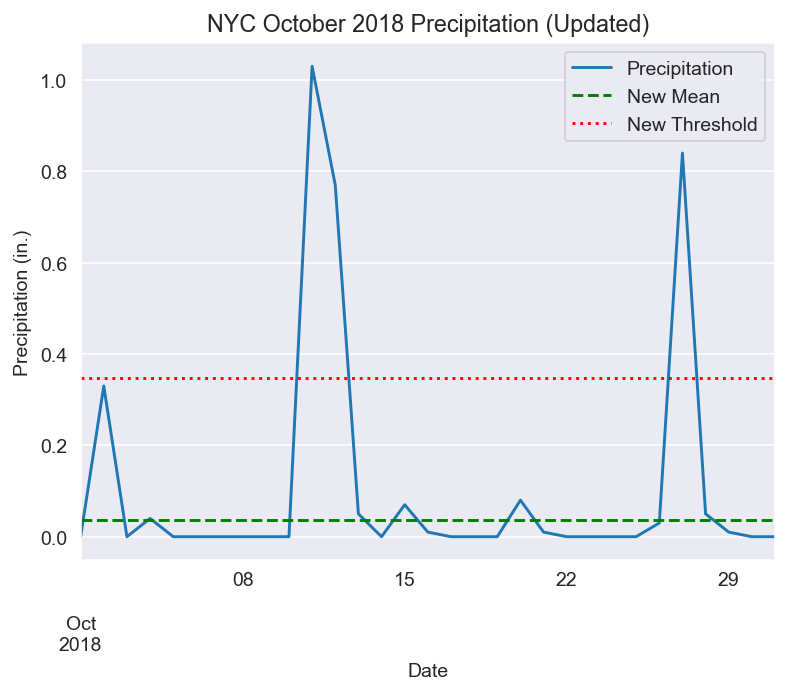

,Precipitation
Date,
2018-10-11,1.03
2018-10-12,0.77
2018-10-27,0.84


In [35]:
# Завантажуємо дані (імовірно, вони зчитуються раніше у df_ppt)
df_ppt = pd.read_csv("nyc_precipitation_oct2018.csv", parse_dates=True, index_col=0)

# Вибираємо перші 10 днів без аномалій
subset = df_ppt.iloc[:10]

# Обчислюємо нові середнє значення та стандартне відхилення
mean_subset = subset.iloc[:, 0].mean()
std_subset = subset.iloc[:, 0].std()

# Визначаємо новий поріг (3 стандартних відхилення)
threshold = 3
cutoff_new = mean_subset + threshold * std_subset

# Візуалізуємо нову контрольну діаграму
plt.figure(dpi=140)
df_ppt.plot(ax=plt.gca())
plt.axhline(y=mean_subset, color='g', linestyle='--', label='New Mean')
plt.axhline(y=cutoff_new, color='r', linestyle=':', label='New Threshold')
plt.legend(loc='best')
plt.title("NYC October 2018 Precipitation (Updated)")
plt.ylabel("Precipitation (in.)")
plt.show()

# Виявляємо нові аномалії
new_anomalies = df_ppt[df_ppt.values > cutoff_new]
new_anomalies

Маємо три аномалії, з яких перша (2018-10-11 1.03) співпадає із раніше виявленою в Секції 1.

## Вправа №2¶
Ця вправа відноситься до розділу 2 (моделі автогресії).

A. Повторіть аналіз значень TMIN.

B. Ви виявили такі ж аномалії, як TMAX?

## Рішення №2

D:\minicond\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\minicond\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\minicond\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\minicond\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\minicond\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\minicond\Lib\site-packages\statsmodel

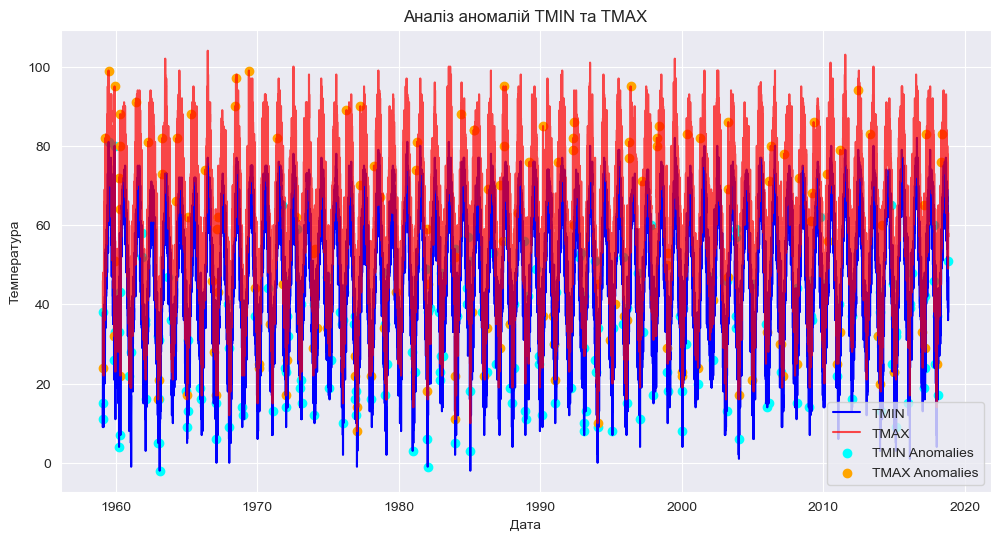

Аномалії у TMIN: DATE
1959-02-01   -32.129440
1959-02-04    17.955040
1959-02-19   -20.343314
1959-06-30    15.713554
1959-11-17   -16.357195
                ...    
2017-11-02    18.371683
2017-11-10   -15.673353
2018-01-11    18.939661
2018-02-02   -15.348714
2018-10-12   -15.142234
Length: 201, dtype: float64
Аномалії у TMAX: DATE
1959-02-01   -37.519936
1959-04-08    24.267838
1959-06-29    25.448909
1959-11-18   -21.323455
1959-12-01    50.926923
                ...    
2017-03-11   -20.365568
2017-04-16    23.711575
2018-01-14   -20.627537
2018-05-01    20.902721
2018-05-20    22.376556
Length: 148, dtype: float64
Спільні аномальні дати: DatetimeIndex(['1959-02-01', '1959-12-01', '1959-12-02', '1960-05-01',
               '1960-05-02', '1963-01-24', '1982-01-10', '2000-01-17',
               '2006-01-15', '2009-02-08'],
              dtype='datetime64[ns]', name='DATE', freq=None)


In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Завантажуємо дані (припустимо, що вони у файлі або вже є у змінній df)
df_temp = pd.read_csv("nyc_daily_temp_final.csv", parse_dates=True, index_col=0)

# Виділяємо стовпці TMIN і TMAX
tmin = df_temp["TMIN"]
tmax = df_temp["TMAX"]

# Будуємо модель ARIMA для TMIN
model_tmin = ARIMA(tmin, order=(2, 0, 2))  # Автопідбір можна зробити через AIC
fit_tmin = model_tmin.fit()

# Прогноз і залишки
residuals_tmin = fit_tmin.resid

# Визначаємо аномалії: якщо залишки виходять за межі 3 стандартних відхилень
threshold_tmin = 3 * residuals_tmin.std()
anomalies_tmin = residuals_tmin[abs(residuals_tmin) > threshold_tmin]

# Аналогічний аналіз для TMAX
model_tmax = ARIMA(tmax, order=(2, 0, 2))
fit_tmax = model_tmax.fit()
residuals_tmax = fit_tmax.resid
threshold_tmax = 3 * residuals_tmax.std()
anomalies_tmax = residuals_tmax[abs(residuals_tmax) > threshold_tmax]

# Порівняння аномалій
common_anomalies = anomalies_tmin.index.intersection(anomalies_tmax.index)

# Візуалізація
plt.figure(figsize=(12, 6))
plt.plot(tmin, label="TMIN", color="blue")
plt.plot(tmax, label="TMAX", color="red", alpha=0.7)
plt.scatter(anomalies_tmin.index, tmin.loc[anomalies_tmin.index], color="cyan", label="TMIN Anomalies")
plt.scatter(anomalies_tmax.index, tmax.loc[anomalies_tmax.index], color="orange", label="TMAX Anomalies")
plt.legend()
plt.title("Аналіз аномалій TMIN та TMAX")
plt.xlabel("Дата")
plt.ylabel("Температура")
plt.show()

# Вивід результатів
print("Аномалії у TMIN:", anomalies_tmin)
print("Аномалії у TMAX:", anomalies_tmax)
print("Спільні аномальні дати:", common_anomalies)

Наша модель знайшла штучно введені нами аномалії (Dec. 1, 1959 and May 1, 1960) та кілька інших.